
# Training a model to detect U.S traffic signs



## The dataset 


The dataset is the [Self-Driving Cars Computer Vision Project](https://universe.roboflow.com/selfdriving-car-qtywx/self-driving-cars-lfjou/dataset/2) provided on the Roboflow website.

The data used is [version 2](https://universe.roboflow.com/selfdriving-car-qtywx/self-driving-cars-lfjou/dataset/2) which includes 4477 images already divided into training (3129 images or 70% of the set), validation (758 or 17%) and test (590 or 13%). Additionally, all images are pre-processed to have size 416x416 pixels and no data augmentation is applied.

![Information about the dataset.](./assets/dataset_details.jpg)

*Information about the dataset.*




## Analyzing the data


### Class distribution


On the Roboflow website it is possible to see the distribution of classes in the dataset, however this information is about the latest one created, which is version 4. Therefore, while this can provide a good idea of the data distribution, it does not accurately represent the dataset we are using, which is version 2.

![The class distribution in version 4 of this dataset.](./assets/dataset_balance.jpg)

*The class distribution in version 4 of this dataset.*

Because of it, we will import the data in COCO JSON format to conduct data analysis and obtain more accurate information.

In [1]:
# Import libraries
from IPython.display import clear_output
from PIL import Image
import json
import pandas as pd
from ultralytics import YOLO
import matplotlib.pyplot as plt
import torch
import cv2
%matplotlib inline

In [2]:
# Downloads the dataset in COCO JSON format
! curl -L "https://universe.roboflow.com/ds/DyOxa06LLg?key=8NgMspeEod" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

clear_output(wait=False)

In [3]:
def plot_class_distribution(path, title, ax):
    """Plots the class distribution from a single COCO JSON file using matplotlib

    Args:
        path (str): the relative path to the COCO file
        title (str): the title of the plot
        ax (matplotlib.axes.Axes): the Axes object to plot the distribution
    """

    with open(path) as f:
        data = json.load(f)

        classes = {dict['id']: dict['name'] for dict in data['categories']}
        classes_count = {dict['id']: 0 for dict in data['categories']}

        for annotation in data['annotations']:
            classes_count[annotation['category_id']] += 1

    num_classes = len(classes)
    classes_list = [None] * num_classes
    classes_count_list = [None] * num_classes
    
    for id, category in classes_count.items():
        classes_list[id] = classes[id]
        classes_count_list[id] = category

    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(title)
    ax.bar(classes_list, classes_count_list)

Here are the graphs showing the real distribution of classes in the training, validation and test sets.

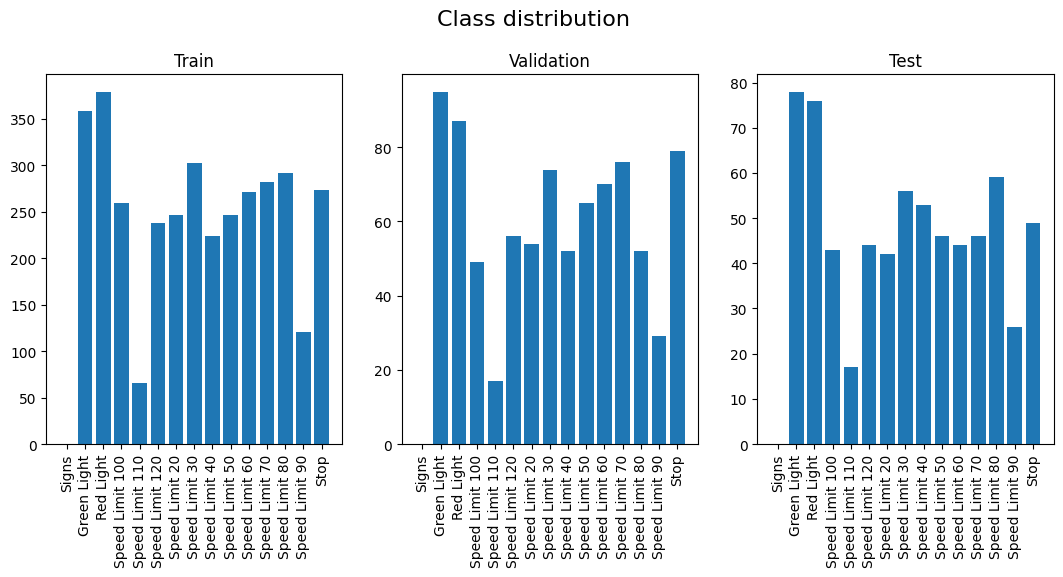

In [4]:
fig, (train, valid, test) = plt.subplots(1, 3, figsize=(13, 5))
fig.suptitle('Class distribution', fontsize=16)
fig.subplots_adjust(top=0.85)
plot_class_distribution('./train/_annotations.coco.json', 'Train', train)
plot_class_distribution('./valid/_annotations.coco.json', 'Validation', valid)
plot_class_distribution('./test/_annotations.coco.json', 'Test', test)
plt.show()

After analyzing the graphs it is possible to draw the following conclusions:

- The first thing to note is that no image belongs to the 'Signs' class and, upon checking the Roboflow website, it becomes apparent that this class is not considered, but only appears due to the COCO JSON format. Additionally, in our dataset we have 14 classes, which is different from the 15 presented on the website and that is because, as mentioned earlier, the data used is older and does not include the 'Speed limit 10' class.

- Checking the graphs we notice that the class distribution is very similar across the three sets of data.

- Finally, we observe that the data exhibits a relatively balanced distribution, as only two classes out of the 14, 'Speed limit 110' and 'Speed limit 90', have few instances while only other two, 'Green Light' and 'Red Light', stand out with significantly more instances than the rest. However, the remaining classes show a very similar distribution with representative numbers of examples.

In [5]:
# after ploting the graphs whe can remove the files
! rm -r test train valid README.dataset.txt README.roboflow.txt


### Original size of images


As all images are pre-processed to have size 416x416 the only way to analyze their original size is through the Roboflow website which may not provide information in the most accurate manner as explained above.

![Distribution of the original size of the images.](./assets/images_dimensions.jpg)

*Distribution of the original size of the images.*

Upon examining the data we notice that a significant portion of the images is quite small, with dimensions smaller than 100x100, while another large portion has dimensions close to the specified size (416x416). The remaining images, which represent a smaller portion of the total, are either much larger than 416x416 or fall within the dimension range between 100x100 and 416x416.


### Examining instances from the dataset


In [6]:
# Donwloads the dataset in YOLOv8 format
! curl -L "https://universe.roboflow.com/ds/s5tubfUJUz?key=dAIVR4GASb" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

clear_output(wait=False)


#### Image quality


It is possible to note a significant difference in the quality of them:

- Because many of them have a very small original dimension, smaller than 100x100, after being converted to the size of 416x416 they become quite challenging to identify as the image loses clarity. Some even become unidentifiable and in this specific case even if the model correctly classifies them this is not very meaningful:

![Image of a traffic sign that can be identified, but has poor quality.](./assets/train/plate1.jpg)

*Image of a traffic sign from the training set that can be identified, but has poor quality.*

![Image of a traffic sign that can be identified, but has poor quality.](./assets/valid/plate1.jpg)

*Image of a traffic sign from the validation set that can be identified, but has poor quality.*

![Image of a traffic sign that cannot be identified with certainty.](./assets/train/plate2.jpg)

*Image of a traffic sign from the training set that cannot be identified with certainty.*

![Image of a traffic sign that cannot be identified with certainty.](./assets/valid/plate2.jpg)

*Image of a traffic sign from the validation set that cannot be identified with certainty.*

- Also, there is a small proportion of images with dimensions much larger than 416x416 making them to become similarly challenging to identify when converted. Some even become impossible to identify and in such cases the model's accuracy is also not very meaningful:

![Image captured by a fisheye camera in which some objects have become very difficult to identify and others even impossible.](./assets/train/plate3.jpg)

*Image captured by a fisheye camera, taken from the training set, in which some objects have become very difficult to identify and others even impossible to distinguish.*

![Image captured by a fisheye camera in which the objects present can not be clearly identified.](./assets/valid/plate3.jpg)

*Image captured by a fisheye camera, taken from the validation set, in which the present objects can not be clearly identified.*

- On the other hand, a large portion of the images have dimensions close to 416x416 resulting in good quality after being converted:

![High-quality image of a traffic sign.](./assets/train/plate4.jpg)

*High-quality image of a traffic sign from the training set.*

![High-quality image of a traffic sign.](./assets/valid/plate4.jpg)

*High-quality image of a traffic sign from the validation set.*


#### Types of images


In addition to various qualities there are basically three main different types of images:

- Images that show detectable objects, such as traffic signs or traffic lights, in a focused and typically centered manner, as shown above.

- Images captured by a fisheye camera causing distortion compared to the real world. These images not only show the focused object but also the entire environment in which it is located, in other words, the object is part of the background, as also shown in the images above.

- Images taken by a regular camera but in the same style as the fisheye, meaning they do not present focused objects and, therefore, are the ones that represent most closely the view of a driver, as shown below:

![Image similar to that of a fisheye camera where objects are not being focused and the entire environment is shown as a whole.](./assets/train/plate5.jpg)

*Image similar to that of a fisheye camera where objects are not being focused and the entire environment is shown as a whole. It belongs to the training set.*

![Image similar to that of a fisheye camera where objects are not being focused and the entire environment is shown as a whole.](./assets/valid/plate5.jpg)

*Image with the same idea as the previous one, but from the validation set.*


#### Diversity of images


It is also noticeable that, despite the dataset being relatively large, it lacks diversity in images. One can observe that many images are very similar to each other and appear to be just different augmentations applied to a single original image, as we can see below:

![Image of a traffic sign.](./assets/train/plate6.jpg)

*Image from the training set.*

![Image of a traffic sign.](./assets/train/plate7.jpg)

*Image from the training set.*

![Image of a traffic sign.](./assets/valid/plate6.jpg)

*Image from the validation set.*

![Image of a traffic sign.](./assets/valid/plate7.jpg)

*Image from the validation set.*


## Creating the first models


For this project a pre-trained object detection model from Ultralytics, YOLOv8, was used along with transfer learning. The model's documentation can be accessed [here](https://docs.ultralytics.com/).

Ultralytics has several models for this task:

![Table with all available object detection models.](./assets/yolo_models.jpg)

*Table with all available object detection models.*

Initially, the YOLOv8n model was chosen because it has fewer parameters making it the simplest and also the fastest to train. Therefore, it was selected to obtain the initial results. Three different models were created, each trained for 30 epochs on a GPU and they were saved in the 'models' directory.


### Model 1


Its configuration can be accessed at ./models/model1_30epochs/args.yaml, but the main settings include a batch size of 16, an initial learning rate of 0.001 and the use of the Adam optimizer. The batch size of 16 was chosen as it was the largest size that could run on the GPU.

In [7]:
# Only run this cell if you want to train a new model
# model = YOLO('yolov8n.pt') # import pre-trained model 

# DATA_PATH = './data.yaml'
# IMGSZ = 416

# # hyperparameters for tuning
# BATCH = 16 
# EPOCHS = 30
# OPTIMIZER = 'Adam'
# LR0 = .001

# results = model.train(
#     data = DATA_PATH,
#     epochs = EPOCHS,
#     batch = BATCH,
#     imgsz = IMGSZ,
#     device = 0,
#     optimizer = OPTIMIZER,
#     lr0 = LR0
# )


### Model 2


Its configuration can be accessed at ./models/model2_30epochs/args.yaml, but the main settings include a batch size of 16 and the other configurations were the default.

In [8]:
# Only run this cell if you want to train a new model
# model = YOLO('yolov8n.pt') # import pre-trained model 

# DATA_PATH = './data.yaml'
# IMGSZ = 416

# # hyperparameters for tuning
# BATCH = 16 
# EPOCHS = 30

# results = model.train(
#     data = DATA_PATH,
#     epochs = EPOCHS,
#     batch = BATCH,
#     imgsz = IMGSZ,
#     device = 0
# )


### Model 3
 

Its configuration can be accessed at ./models/model3_30epochs/args.yaml, but the main settings include a batch size of 8 and the other configurations were the default.

In [9]:
# Only run this cell if you want to train a new model
# model = YOLO('yolov8n.pt') # import pre-trained model for object detection

# DATA_PATH = './data.yaml'
# IMGSZ = 416

# # hyperparameters for tuning
# BATCH = 8 # the best size for my GPU
# EPOCHS = 30

# results = model.train(
#     data = DATA_PATH,
#     epochs = EPOCHS,
#     batch = BATCH,
#     imgsz = IMGSZ,
#     device = 0
# )


## Analyzing the results


The results are in ./models/modelX_30epochs where modelX is the specific model such as model1.


### Precision Recall Curve


We observe that all models exhibit a very similar curve and the lowest mAP50 values are for the 'Green Light' and 'Red Light' classes.

![Precision Recall Curve of model 1.](models/model1_30epochs/PR_curve.png)

*Precision Recall Curve of model 1.*

![Precision Recall Curve of model 2.](models/model2_30epochs/PR_curve.png)

*Precision Recall Curve of model 2.*

![Precision Recall Curve of model 3.](models/model3_30epochs/PR_curve.png)

*Precision Recall Curve of model 3.*


### Metrics of the models


Looking only at the final metrics we can see that all models present very good and similar results.

In [10]:
# Show the final metrics of the models
model1_df = pd.read_csv('./models/model1_30epochs/results.csv')
model2_df = pd.read_csv('./models/model2_30epochs/results.csv')
model3_df = pd.read_csv('./models/model3_30epochs/results.csv')

df_cols = model1_df.columns
metrics = [df_cols[0], df_cols[4], df_cols[5], df_cols[6], df_cols[7]]

print('Model 1 metrics')
display(model1_df[metrics].tail(1))

print('Model 2 metrics')
display(model2_df[metrics].tail(1))

print('Model 3 metrics')
display(model3_df[metrics].tail(1))

Model 1 metrics


,epoch,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B)
29,30,0.96709,0.88758,0.94636,0.8347


Model 2 metrics


,epoch,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B)
29,30,0.95526,0.90608,0.95416,0.83461


Model 3 metrics


,epoch,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B)
29,30,0.96623,0.899,0.95137,0.83156


When analyzing the training graphs we also notice that they are very similar.

![Training graph of model 1.](./models/model1_30epochs/results.png)

*Training graph of model 1.*

![Training graph of model 2.](./models/model2_30epochs/results.png)

*Training graph of model 2.*

![Training graph of model 3.](./models/model3_30epochs/results.png)

*Training graph of model 3.*


### Predictions of the models


An important observation is that some images contain many objects and only a few of them are labeled in the original, however, in some cases, the models detect these unidentified objects, even though with a low probability. Additionally, we can see that all models present very good results. Below are some images from the validation set in their original format and those predicted by the models:

![16 original images from the validation set.](models/model1_30epochs/val_batch0_labels.jpg)

*Original images from the validation set.*

![The same images predicted by model 1.](models/model1_30epochs/val_batch0_pred.jpg)

*The same images predicted by model 1.*

![The same images predicted by model 2.](models/model2_30epochs/val_batch0_pred.jpg)

*The same images predicted by model 2.*

![The same images predicted by model 3.](models/model3_30epochs/val_batch0_pred.jpg)

*The same images predicted by model 3.*


### Confusion Matrix for classification


Below are the normalized confusion matrices for classification of the three models. We observe that they are very similar, but the classes that have poorer classification are, once again, 'Green Light' and 'Red Light'.

![Normalized Confusion Matrix for model 1.](models/model1_30epochs/confusion_matrix_normalized.png)

*Normalized Confusion Matrix for model 1.*

![Normalized Confusion Matrix for model 2.](models/model2_30epochs/confusion_matrix_normalized.png)

*Normalized Confusion Matrix for model 2.*

![Normalized Confusion Matrix for model 3.](models/model3_30epochs/confusion_matrix_normalized.png)

*Normalized Confusion Matrix for model 3.*


### Initial conclusions


- Looking at the results obtained and after cheking the images from the train and validation set, we can correlate that the low metrics for the 'Red Light' and 'Green Light' classes are linked to the fact that in the original dataset many objects of these classes are not identified and, the models after training, identify them causing the precision metric to decrease and, consequently, the mAP metric as this is interpreted as an error. Therefore, the precision metric and all others related to it should be carefully analyzed.

- Excluding these two classes, it seems that the other classes are well-identified in the original dataset, as this issue does not occur with them.

- In the end all models showed very good and similar performance, but the one that appears to have the best results is Model 2. Therefore, it will be trained for more 20 epochs for future analysis as its graph indicates that the model can further improve.


## Training model 2


Its configuration can be accessed at ./models/model2_30-50epochs/args.yaml, but the main settings include an initial learning rate of 1e-6 and the AdamW optimizer.

In [11]:
# Creates a new configuration for training
weights = torch.load('models/model2_30epochs/weights/last.pt')

conf = weights['train_args']
conf['epochs'] = 20
conf['patience'] = 10
conf['save_period'] = -1
conf['optimizer'] = 'AdamW'
conf['lr0'] = 1e-6

torch.save(weights, 'models/model2_30epochs/weights/last_update.pt')

In [12]:
# Only run this cell if you want to train a new model
# model = YOLO('models/model2_30epochs/weights/last_update.pt') # Train model 2 for more 20 epochs

# model.train(resume=True)


## Analyzing final results on validation set


The results are in ./models/model2_30-50epochs


### Precision Recall Curve


The Precision Recall Curve did not change much after the training.

![Precision Recall Curve of the model.](./models/model2_30-50epochs/PR_curve.png)

*Precision Recall Curve of the model.*


### Metrics 


The graphs show that the model did not improve significantly, so there is no need to keep training.

![Training graph of the model.](./models/model2_30-50epochs/results.png)

*Training graph of the model.*


### Predictions 


As expected the predictions also did not change much.

![Batch from the validation set predicted by the model.](./models/model2_30-50epochs/val_batch0_pred.jpg)

*Batch from the validation set predicted by the model.*


### Confusion Matrix for classification


The normalized confusion matrix did not change much.

![Normalized confusion matrix of the model.](./models/model2_30-50epochs/confusion_matrix_normalized.png)

*Normalized confusion matrix of the model.*


## Analyzing final results on test set


The results are in ./models/model2_30-50epochs/val

In [13]:
# # Only run this cell if you want to validate again in the test set
# model = YOLO('./models/model2_30-50epochs/weights/last.pt')

# metrics = model.val(split='test')


### Precision Recall Curve


The curve is not much different from the one of the validation set, however the metric mAP50 for the class 'Green Light' is higher.

![Precision recall curve of the model.](./models/model2_30-50epochs/val/PR_curve.png)

*Precision Recall Curve of the model.*


### Predictions


The model's predictions are still very accurate and it continues to detect objects that are not labeled in the original images.

![16 original images from the test set.](./models/model2_30-50epochs/val/val_batch1_labels.jpg)

*16 original images from the test set.*

![The same images predicted by the model.](./models/model2_30-50epochs/val/val_batch1_pred.jpg)

*The same images predicted by the model.*

However, the model missclassifies images that are easy for a humam to identify, such as the plate of speed limit 20 and the red light.

![16 original images from the test set.](./models/model2_30-50epochs/val/val_batch2_labels.jpg)

*16 original images from the test set.*

![The same images predicted by the model.](./models/model2_30-50epochs/val/val_batch2_pred.jpg)

*The same images predicted by the model.*


### Confusion Matrix for Classification


The normalized confusion matrix still looks good, however the number of incorrectly detected instances for the 'Speed Limit 60' class has increased.

![Normalized Confusion Matrix of the model.](./models/model2_30-50epochs/val/confusion_matrix_normalized.png)

*Normalized Confusion Matrix of the model.*


## Final conclusions


Overall the model performs really well and got a mAP50 of 0.950 on the test set, while being trained for only 50 epochs. To compare, the [Roboflow model](https://universe.roboflow.com/selfdriving-car-qtywx/self-driving-cars-lfjou/dataset/2) got a mAP50 of approximately 0.960 on the test set and was trained for more than 200 epochs.

Things to keep in mind are that the dataset is not very much challenging. Even tough there are many images, a lot of them are very similar and many only show the plates or the traffic lights, centralized and with good resolution, as discussed in the beggining of the notebook.


## Using the model


To use the model first download the images you will use, set the path to them and run the cell bellow. Make sure the objects in the images match the classes that were used for training.

In [14]:
img_path = './path/to/image' # set the image path

IMG_WIDTH, IMG_HEIGHT = (416, 416)

img = cv2.imread(img_path)

img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)) # resizes image

model = YOLO('./models/model2_30-50epochs/weights/last.pt')

result = model(img_resized)

for r in result: # plots prediction
    im_arr = r.plot()
    im = Image.fromarray(im_arr[..., ::-1])
    im.show()